# <center> Interpolación

$ \newcommand{\mymatrix}[2]{\left[ \begin{array}{#1} #2\end{array} \right]} $

El problema es simple: **Tenemos un conjunto de puntos de datos y queremos encontrar una función que pase exactamente por todos ellos**.

<center> Curve fitting vs interpolación

<div>
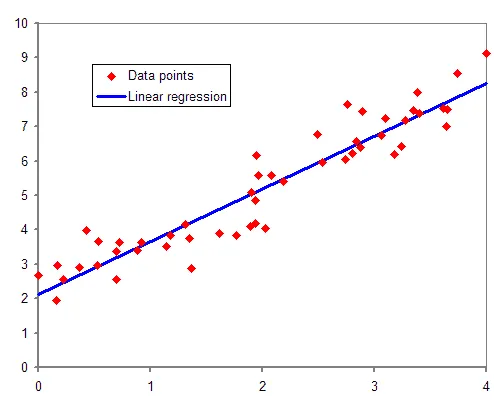
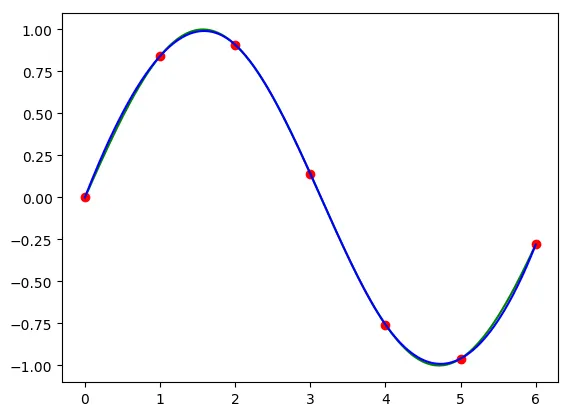
</div>

La pregunta no es si podemos hacerlo, sino cómo lo hacemos de la mejor manera. La respuesta más sencilla suele ser usar un polinomio, porque son funciones simples de evaluar, derivar e integrar. :)


Entonces, dados $m+1$ pares de puntos $(x_i, y_i)$, el problema consiste en encontrar una función $\Pi$ tal que $\Pi(x_i) = y_i$ para cada $i = 0,...,m$, y entonces decimos que la función $\Pi$ _interpola_ {$y_i$} en los nodos {$x_i$}.

Hay un teorema que nos garantiza que podemos hacerlo:

**Teorema:** _Dados $n+1$ puntos distintos $x_0,..., x_n$ y sus correspondientes $n+1$ valores $y_0,..., y_n$, existe un único polinomio $\Pi_n \in P_n$ tal que $\Pi(x_i) = y_i$ para $i=0,...,n$._

## Ejemplo: Mercados financieros

Supongamos que estamos siguiendo una nueva y volátil criptomoneda, la llamaremos "fcoin". Debido a un fallo en el sistema de recolección de datos, solo tenemos el precio de cierre en ciertos días específicos durante sus primeras dos semanas.

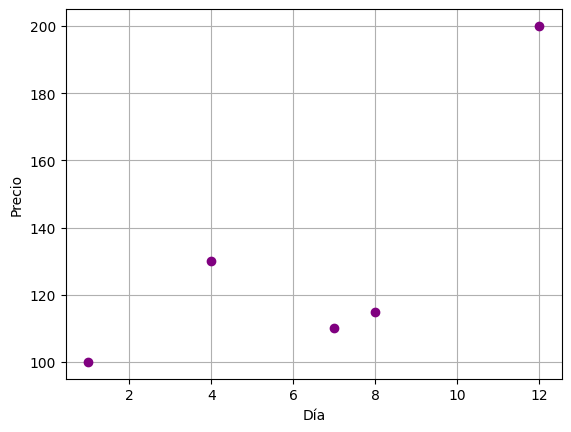

In [1]:
import numpy as np
import matplotlib.pyplot as plt

dias = np.array([1, 4, 7, 8, 12])
precios = np.array([100, 130, 110, 115, 200])

plt.plot(dias, precios, 'o', color='purple')
plt.xlabel('Día')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

### Polinomios de Lagrange

Construimos el polinomio $\Pi_n(x)$ como una suma ponderada. La clave está en crear una serie de _polinomios base_ $L_i(x)$, cada uno asociado a un punto $(x_i, y_i)$, que está diseñado para funcionar como un "interruptor":
* Vale 1 exactamente en $x_i$.
* Vale 0 en todos los demás puntos $x_j$ (con $j \neq i$).

y entonces lograr que el polinomio interpolador quede escrito como
$$ \Pi_n(x) = \sum_{i=0}^n y_i L_i(x) $$

los polinomios de la base tienen la forma
$$ L_i(x) = \prod_{\substack{j=0,\\ j \neq i}}^n \frac{x-x_j}{x_i - x_j} = \frac{(x-x_0)...(x-x_{i-1})(x-x_{i+1})...(x-x_n)}{(x_i-x_0)...(x_i-x_{i-1})(x_i-x_{i+1})...(x_i-x_n)} $$

Notemos que $L_i(x_j) = \delta_{ij}$

In [2]:
def polinomio_base(a, i, x_data):
    """Calcula el i-ésimo polinomio base de Lagrange (Li) para el valor 'a'."""
    Li = 1
    xi = x_data[i]
    for j, xj in enumerate(x_data):
        if i != j:
            Li *= (a - xj) / (xi - xj)
    return Li

def polinomio_lagrange(a, x_data, y_data):
    """Calcula el valor del polinomio de Lagrange completo en el valor 'a'."""
    Pi = 0
    for i, yi in enumerate(y_data):
        Pi += yi * polinomio_base(a, i, x_data)
    return Pi

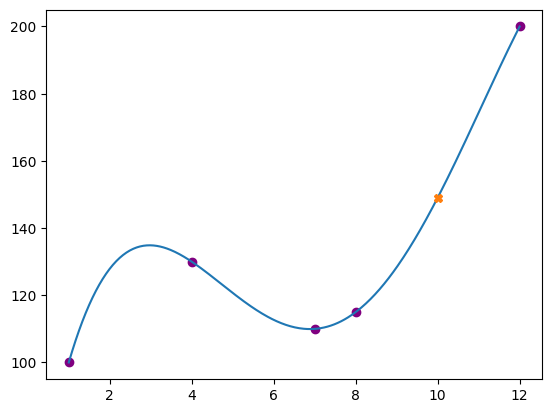

In [3]:
p10 = polinomio_lagrange(10, dias, precios)
p10

dias_new = np.linspace(dias.min(), dias.max(), 400)
precios_lagrange = polinomio_lagrange(dias_new, dias, precios)

plt.scatter(dias, precios, color="purple")
plt.plot(dias_new, precios_lagrange)
plt.plot(10, p10, 'X')

### Polinomios de Newton

También llegamos a un único polinomio que interpola nuestros datos, pero de una forma un poco más eficiente. Para evitar el problema anterior, donde Lagrange no es un polinomio incremental, pues lo construimos de manera incremental jiji.

En lugar de construir todo de golpe, Newton construye el polinomio paso a paso.

* El polinomio de grado 0 que pasa por $(x_0, y_0)$ es $\Pi_0(x) = y_0$.

* El polinomio de grado 1 que pasa por los dos primeros puntos es el anterior más un término de corrección: $\Pi_1(x) = \Pi_0(x) + a_1(x-x_0)$.

* El polinomio de grado 2 es el anterior más otra corrección: $\Pi_2(x) = \Pi_1(x) + a_2(x-x_0)(x-x_1)$.
...y así sucesivamente.

Y por lo tanto,
$$ \Pi_n(x) = a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) + ... $$
$$ = \Pi_{n-1}(x) + q_n(x)$$

El secreto está en encontrar los coeficientes $a_i$, llamados **diferencias divididas**.

$a_0 = f[x_0] = y_0$

$a_1 = f[x_0, x_1] = \frac{y_1 - y_0}{x_1 - x_0}$

$a_2 = f[x_0, x_1, x_2] = \frac{f[x_1, x_2] - f[x_0, x_1]}{x_2 - x_0}$

Se calculan de forma recursiva y se suelen organizar en una tabla:

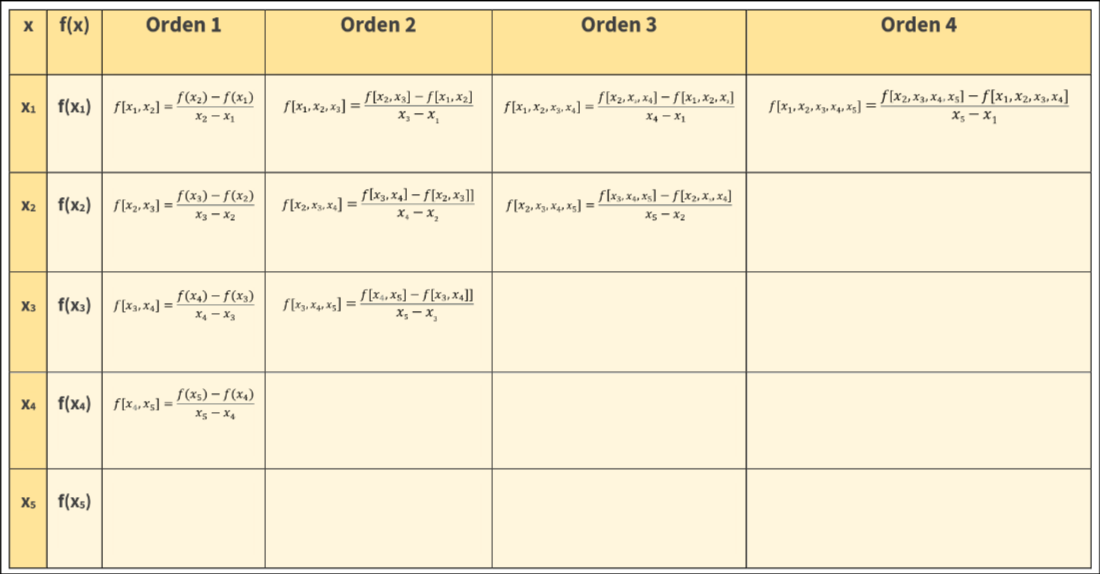

In [4]:
def tabla_difdiv(x_data, y_data):
    """Calcula la tabla de diferencias divididas de Newton."""
    n = len(y_data)
    tabla = np.zeros([n, n])
    tabla[:,0] = y_data
    
    for j in range(1, n):
        for i in range(n - j):
            tabla[i,j] = (tabla[i+1,j-1] - tabla[i,j-1]) / (x_data[i+j] - x_data[i])
    return tabla

In [5]:
np.set_printoptions(precision=2, suppress=True, floatmode='fixed')
tabla_dd = tabla_difdiv(dias, precios)
coeffs_newton = tabla_dd[0,:]
coeffs_newton

array([100.00,  10.00,  -2.78,   0.81,  -0.07])

In [6]:
def polinomio_newton(a, x_data, coeffs):
    """Evalúa el polinomio de Newton."""
    n = len(coeffs) - 1
    Pi = coeffs[n]
    for i in range(n-1, -1, -1):
        Pi = Pi*(a - x_data[i]) + coeffs[i]
    return Pi

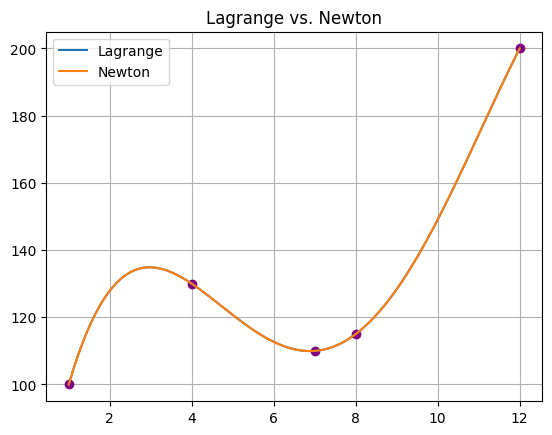

In [7]:
p10 = polinomio_newton(10, dias, coeffs_newton)

dias2 = np.linspace(dias.min(), dias.max(), 400)
precios_newton = polinomio_newton(dias2, dias, coeffs_newton)

plt.plot(dias, precios, 'o', color='purple')
plt.plot(dias2, precios_lagrange, label='Lagrange')
plt.plot(dias2, precios_newton, label='Newton')
plt.title('Lagrange vs. Newton')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import time

puntos = np.linspace(dias.min(), dias.max(), 10000)

# Lagrange
ti_lagrange = time.time()
resultados_lagrange = [polinomio_lagrange(d, dias, precios) for d in puntos]
tf_lagrange = time.time()
print(f"Tiempo total de Lagrange: {tf_lagrange - ti_lagrange:.6f} segundos.")

# Newton
# construir la tabla (se hace una sola vez)
ti_tabla = time.time()
coeficientes = tabla_difdiv(dias, precios)[0, :]
tf_tabla = time.time()
ttabla = tf_tabla - ti_tabla
# evaluación
ti_newton = time.time()
resultados_newton = polinomio_newton(puntos, dias, coeficientes)
tf_newton = time.time()
tnewton = tf_newton - ti_newton

print(f"Tiempo total de Newton: {ttabla + tnewton:.6f} segundos.")

Tiempo total de Lagrange: 0.172528 segundos.
Tiempo total de Newton: 0.000362 segundos.


### Fenómeno de Runge

Bueno, pero a todo esto, ¿significa que si tengo 50 puntos, debería usar un polinomio de grado 49?

Continuando con el ejemplo del mercado financiero, supongamos que tenemos más datos del precio de la cripto en ciertos días de las primeras dos semanas.

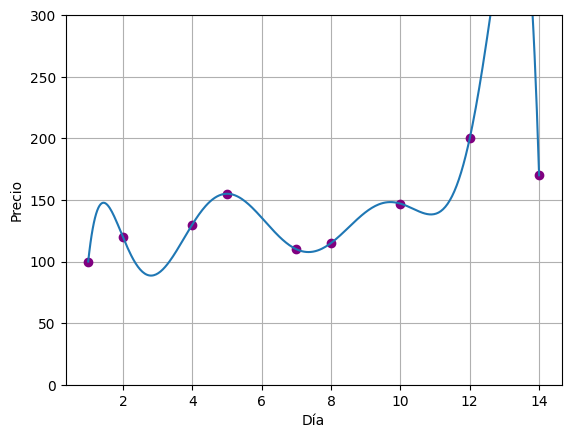

In [9]:
dias = np.array([1, 2, 4, 5, 7, 8, 10, 12, 14])
precios = np.array([100, 120, 130, 155, 110, 115, 147, 200, 170])

# Vamos a aplicar el método de Newton a estos 9 puntos
coeffs = tabla_difdiv(dias, precios)[0,:]
dias2 = np.linspace(dias.min(), dias.max(), 400)
precios_newton = polinomio_newton(dias2, dias, coeffs)

plt.plot(dias, precios, 'o', color='purple')
plt.plot(dias2, precios_newton)
plt.xlabel('Día')
plt.ylabel('Precio')
plt.ylim(0, 300) # Ajustamos el eje Y para ver el problema
plt.grid(True)
plt.show()

Nuestro modelo pasa por todos los puntos, sí, pero ¿el precio realmente se disparó el día 13 y bajó el día 3?...

Pues no. El modelo está inventando una volatilidad que no existe en nuestros datos.

Este es un fenómeno matemático llamado **fenómeno de Runge**. Los polinomios de alto grado tienen una tendencia natural a oscilar salvajemente entre los puntos de datos. Aunque pasen exactamente por los puntos que le dimos, pueden comportarse de forma terrible en las zonas intermedias.

El error teórico de la interpolación $E(x) = f(x) - \Pi(x)$ es:

$$E(x) = \frac{f^{n+1}(c)}{(n+1)!} (x-x_0)(x-x_1)...(x-x_n)$$

* $f^{n+1}(c)$: El error depende de qué tan ondulada es la función original (sus derivadas superiores).

* $(x-x_0)...(x-x_n)$: El error es cero en los nodos y más grande cuando x está lejos de ellos, especialmente cerca de los extremos del intervalo.

Nuestro modelo es matemáticamente correcto, pero prácticamente inútil. :(

#### La función de Runge:
$$ f(x) = \frac{1}{1 + 25x^2} $$

Es una función suave y bien comportada, es simétrica y infinitamente derivable. Parece perfecta para una interpolación exitosa. Vamos a interpolar con Newton en el intervalo `[-1, 1]`.

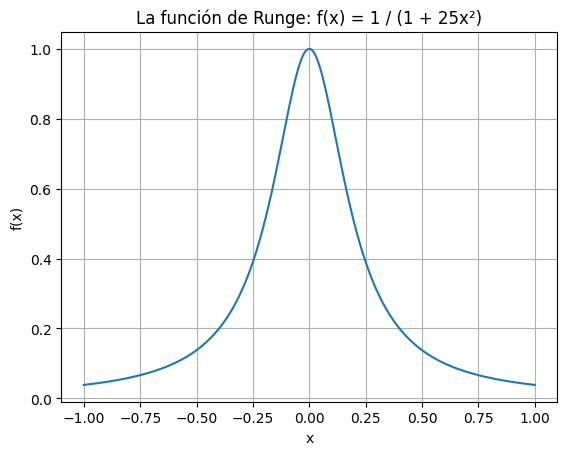

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos la función de Runge
def frunge(x):
    return 1 / (1 + 25 * x**2)

# Puntos para graficar la curva real
x_real = np.linspace(-1, 1, 400)
y_real = frunge(x_real)

# Grafiquemos la función para ver cómo es
plt.plot(x_real, y_real)
plt.title('La función de Runge: f(x) = 1 / (1 + 25x²)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

Interpolaremos la función usando 5, 11 y 21 puntos equiespaciados en el intervalo `[-1, 1]` y veremos qué sucede.

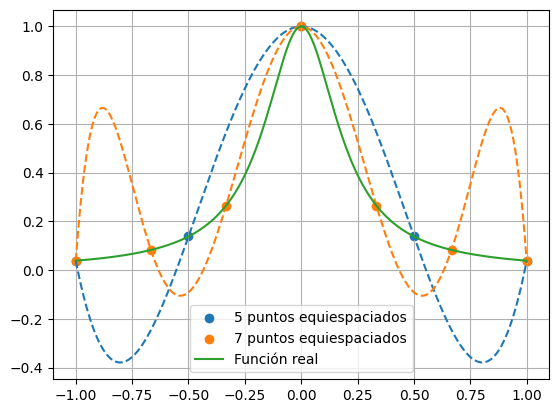

In [11]:
ns = [5,7]
for n in ns:
    x_equi = np.linspace(-1, 1, n)
    y_equi = frunge(x_equi)
    
    coeffs = tabla_difdiv(x_equi, y_equi)[0, :]
    y_interp = polinomio_newton(x_real, x_equi, coeffs)
    
    plt.scatter(x_equi, y_equi, label=f'{n} puntos equiespaciados')
    plt.plot(x_real, y_interp, '--')
plt.plot(x_real, y_real, label='Función real')
plt.legend()
plt.grid(True)
plt.show()

### Nodos de Chebyshev

El problema de los puntos equiespaciados es que dejan los extremos del intervalo "desprotegidos". La solución es usar puntos que no estén espaciados uniformemente, sino que se acumulen cerca de los extremos. Estos puntos mágicos se llaman **nodos de Chebyshev**.

La fórmula para encontrarlos en el intervalo `[-1, 1]` es

$x_k = \cos(\frac{\pi(2k-1)}{2n})$ para $k=1, ..., n+1$

No se asusten por la fórmula, sólo en su efecto que es agrupar los puntos en los bordes.

In [12]:
def chebyshev_nodes(n):
    """Genera n nodos de Chebyshev en el intervalo [-1, 1]."""
    k = np.arange(1, n + 1)
    nodes = np.cos((2 * k - 1) * np.pi / (2 * n))
    return np.sort(nodes) # Los ordenamos para graficar

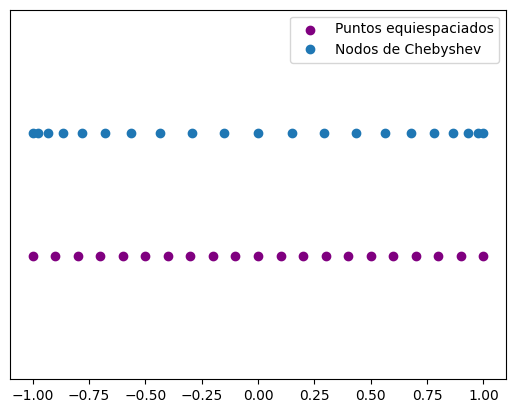

In [13]:
n = 21
x_equi = np.linspace(-1, 1, n)
x_cheby = chebyshev_nodes(n)

plt.scatter(x_equi, np.zeros_like(x_equi), color='purple', label='Puntos equiespaciados')
plt.plot(x_cheby, np.ones_like(x_cheby), 'o', label='Nodos de Chebyshev')
plt.ylim(-1, 2)
plt.legend()
plt.yticks([])
plt.show()

Ahora repitamos el experimento

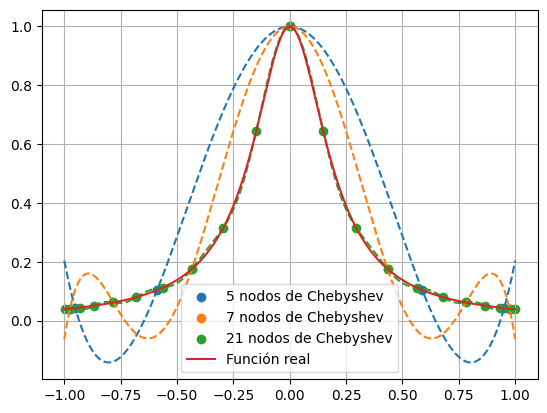

In [14]:
ns = [5,7,21]
for n in ns:
    x_cheby = chebyshev_nodes(n)
    y_cheby = frunge(x_cheby)
    
    coeffs = tabla_difdiv(x_cheby, y_cheby)[0, :]
    y_interp = polinomio_newton(x_real, x_cheby, coeffs)
    
    plt.scatter(x_cheby, y_cheby, label=f'{n} nodos de Chebyshev')
    plt.plot(x_real, y_interp, '--')
plt.plot(x_real, y_real, label='Función real')
plt.legend()
plt.grid(True)
plt.show()

### Splines

Muy bien, pero una solución más inteligente y el estándar allá ajuera, es usar **splines**. La idea detrás de los splines es dividir los puntos en **pares de puntos**. Así, en lugar de tener un polinomio de grado alto, tenemos muchos polinomios de grado bajo.

#### Splines lineales

Un spline lineal es simplemente... conectar los puntos con líneas. buuuuu.

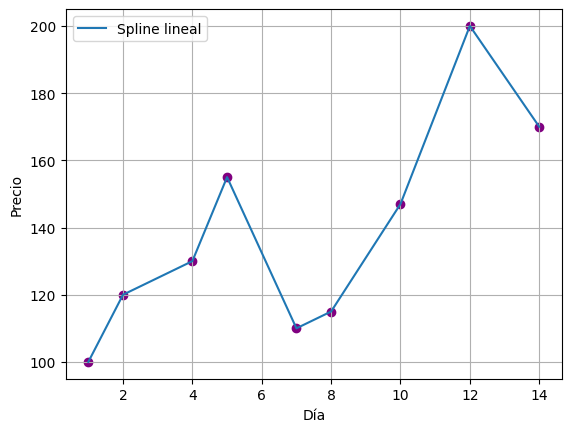

In [15]:
# volvemos a declarar, nomás para que no se nos olvide quien es quien
dias = np.array([1, 2, 4, 5, 7, 8, 10, 12, 14])
precios = np.array([100, 120, 130, 155, 110, 115, 147, 200, 170])
dias2 = np.linspace(dias.min(), dias.max(), 400)

plt.scatter(dias, precios, color='purple')
plt.plot(dias, precios, '-', label='Spline lineal') # Conectar con líneas
plt.xlabel('Día')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

* Ventaja: No hay oscilaciones. El modelo es estable y se mantiene cerca de los datos.
* Desventaja: Los picos en cada punto de datos. La curva no es suave y entonces la derivada no es continua.

Necesitamos lo mejor de ambos mundos: la estabilidad de los splines lineales, pero la suavidad de un polinomio. La solución es el estándar de la industria: los **splines cúbicos**.

#### Splines cúbicos

La idea es la misma: conectamos cada par de puntos con su propio polinomio. Pero esta vez, usamos un polinomio de grado 3 para cada segmento.

¿Por qué cúbico? Porque nos da suficientes grados de libertad para imponer condiciones de suavidad. En cada punto de datos interno, forzamos a que:

* Los dos segmentos de curva se encuentren (la función es continua).
* Tengan la misma pendiente (la primera derivada es continua).
* Tengan la misma curvatura (la segunda derivada es continua).

Al imponer todas estas condiciones, obtenemos un sistema de ecuaciones lineales que podemos resolver para encontrar los coeficientes de todos nuestros pequeños polinomios cúbicos.

##### Explicación de cómo se forma este sistema
<div style="font-size: 0.8em; color: gray">
Nuestra meta es conectar $n+1$ puntos $(x_0, y_0), ..., (x_n, y_n)$ usando n polinomios cúbicos diferentes, uno para cada intervalo $[x_i, x_{i+1}]$.
    
Llamemos al polinomio en el i-ésimo intervalo $S_i(x)$. La forma general de este polinomio es:

$$S_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3$$

Tenemos $n$ intervalos. Cada intervalo tiene 4 coeficientes $(a_i, b_i, c_i, d_i)$. Por lo tanto, tenemos un total de $4n$ incógnitas que necesitamos encontrar. Para resolverlo, necesitamos construir un sistema de $4n$ ecuaciones, pero vamos a establecer las reglas que nuestra curva final debe obedecer, y cada regla nos dará una o más ecuaciones.
    
- El polinomio $S_i(x)$ debe empezar en el punto $(x_i, y_i)$.
    $$S_i(x_i) = y_i$$
    Si sustituimos $x = x_i$ en nuestra fórmula, obtenemos: $a_i + b_i(0) + c_i(0) + d_i(0) = y_i$<br>
    Esto nos da una solución inmediata, $a_i = y_i$, y proporciona $n$ ecuaciones. Quedan $3n$.

- El polinomio $S_i(x)$ debe terminar en el punto $(x_{i+1}, y_{i+1})$.
    $$S_i(x_{i+1}) = y_{i+1}$$
    Esto nos da la ecuación: $a_i + b_i(h_i) + c_i(h_i)^2 + d_i(h_i)^3 = y_{i+1}$, donde $h_i = x_{i+1} - x_i$.<br>
    Esto nos proporciona otras $n$ ecuaciones. Quedan $2n$

- Las pendientes deben coincidir (continuidad de la primera derivada).
    La derivada de $S_i(x)$ es $S'_i(x) = b_i + 2c_i(x - x_i) + 3d_i(x - x_i)^2$.
    En un punto interior $x_i$, la pendiente de la curva que termina $(S_{i-1})$ debe ser igual a la pendiente de la curva que empieza $(S_i)$.
    $$S'_{i-1}(x_i) = S'_i(x_i)$$
    Esto nos da una ecuación para cada nodo interior $(i = 1, ..., n-1)$, lo que nos proporciona $n-1$ ecuaciones.

- La curvatura debe coincidir (continuidad de la segunda derivada).
    La segunda derivada de $S_i(x)$ es $S''_i(x) = 2c_i + 6d_i(x - x_i)$.
    De manera similar, en un punto interior $x_i$, la curvatura de la curva que termina debe ser igual a la de la que empieza.
    $$S''_{i-1}(x_i) = S''_i(x_i)$$
    Esto nos da otra ecuación para cada nodo interior, proporcionando $n-1$ ecuaciones más.

Así, tenemos $4n-2$, pero $4n$ incógnitas...

Las dos ecuaciones que faltan provienen de decidir qué pasa en los extremos de la curva: en $x_0$ y $x_n$. No tenemos una "curva anterior" a $x_0$ ni una "curva posterior" a $x_n$ para imponer condiciones de suavidad. Así que tenemos que tomar una decisión, la elección más común y simple es la del **spline natural**:

Se asume que la curvatura en los extremos es cero. Es como si la curva se volviera recta en sus puntos finales.
    $$S''_0(x_0) = 0$$
    $$S''_{n-1}(x_n) = 0$$

Y ahí están nuestras 2 ecuaciones faltantes. Ahora tenemos un sistema de $4n$ ecuaciones para $4n$ incógnitas.
</div>

Y nosotros ya sabemos resolver sistemas de ecuaciones lineales, wuuu.

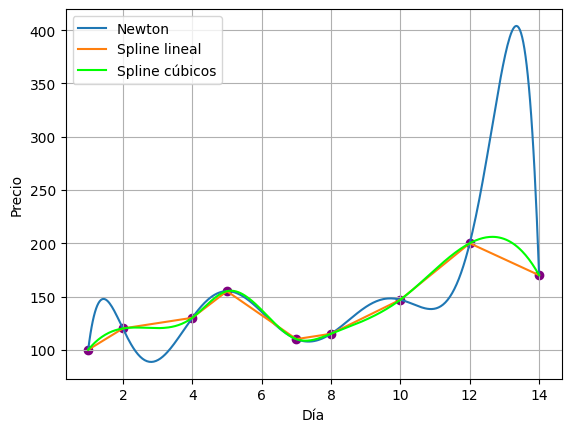

In [16]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(dias, precios)
precios_spline = cs(dias2)

plt.scatter(dias, precios, color='purple')
plt.plot(dias2, precios_newton, label="Newton")
plt.plot(dias, precios, '-', label='Spline lineal')
plt.plot(dias2, precios_spline, color='lime', label="Spline cúbicos")
plt.xlabel('Día')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

Conclusión:

* Interpolación Polinomial (Lagrange/Newton): Útil para un número pequeño de puntos de datos bien comportados. Peligrosa para conjuntos de datos grandes.

* Interpolación con Splines: El método preferido para conjuntos de datos más grandes o cuando se requiere una curva suave y estable. Es el estándar en gráficos por computadora, diseño de ingeniería y análisis de datos.